In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install --quiet torchviz
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
import time
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import seaborn as sn
from copy import deepcopy, copy
import math
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
import time
import matplotlib
warnings.filterwarnings('ignore')
import torch.nn.functional as tF

In [17]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def training_step(model,f_loss,opt):
  #So we can stick this in the loop and it does things
  def actually_train(x,y):

    model.train() #Gotta set it for reasons unknown

    #Step 1: Make yhat
    yhat = model(x)

    #Step 2: Get loss
    Loss = f_loss(yhat,y)

    #Step 3: Grad:
    Loss.backward()

    #Step 4: Optimizer Update
    optimizer.step()
    optimizer.zero_grad()#always do this

    #Give back loss:
    return Loss
  #Now call the lil function
  return actually_train

In [18]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
from google.colab import files
uploaded = files.upload()

Saving Test.csv to Test (1).csv
Saving Train.csv to Train (1).csv


In [20]:
import zipfile
import os

Train_Images = zipfile.ZipFile('/content/gdrive/MyDrive/Colab Notebooks/COS/Assignment 3/Actual_Work/Train_Images.zip', 'r') #Opens the zip file in read mode
Train_Images.extractall('/tmp') #Extracts the files into the /tmp folder
Train_Images.close()

In [21]:
df = pd.read_csv("Train.csv")
df.head

<bound method NDFrame.head of          Image_ID            class   xmin   ymin  width  height
0     ID_007FAIEI  fruit_woodiness   87.0   87.5  228.0   311.0
1     ID_00G8K1V3  fruit_brownspot   97.5   17.5  245.0   354.5
2     ID_00WROUT9  fruit_brownspot  156.5  209.5  248.0   302.5
3     ID_00ZJEEK3    fruit_healthy  125.0  193.0  254.5   217.0
4     ID_018UIENR  fruit_brownspot   79.5  232.5  233.5   182.0
...           ...              ...    ...    ...    ...     ...
3901  ID_ZZAB1FH1    fruit_healthy   96.0  175.5  289.5   222.0
3902  ID_ZZAB1FH1    fruit_healthy  330.0  241.0  182.0   180.5
3903  ID_ZZJZ2CV6    fruit_healthy  358.0  234.0  134.5   107.0
3904  ID_ZZJZ2CV6    fruit_healthy   98.5  135.0  275.5   213.5
3905  ID_ZZO9KIH9  fruit_woodiness  123.5  218.5  197.5   153.5

[3906 rows x 6 columns]>

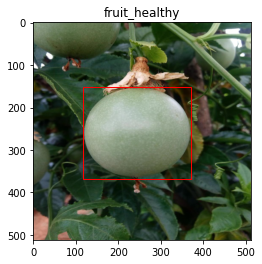

In [24]:
n = 679
bboxes =  df[["xmin","ymin","width","height"]]
bboxes = np.array(bboxes)
id = df.iloc[n]["Image_ID"]
Class = df.iloc[n]["class"]
img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
imgplot = plt.imshow(img)
bbox = bboxes[n]
plt.title(Class)
in_xs = [0,0,512,200]
def coords_to_bbox(coords):
  xmin = coords[0]
  ymin = coords[1]
  xmax = coords[2]
  ymax = coords[3]
  w = xmax-xmin
  h = ymax-ymin
  bbox = [xmin,ymin,w,h]
  return bbox
#bbox = coords_to_bbox(in_xs)
bbox = bbox
plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

def bbox_to_scaled_coords(bbox):
  xmin = bbox[0]
  ymin = bbox[1]
  w = bbox[2]
  h = bbox[3]
  xmax = xmin+w
  ymax = ymin+h
  orig = [xmin, ymin, xmax, ymax]
  scaled_Box = [x / 512 for x in orig]
  return np.array(scaled_Box)

def class_binarizer(CLASS):
  n = 0 
  for c in ['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy']:
    if CLASS  == c:
      clss = n
    else:
      n+=1
  return clss
def class_one_hot(CLASS):
  out = np.zeros(3)
  clss = class_binarizer(CLASS)
  out[clss]+=1
  return out

def class_writer(clss):
  n = np.where(clss==1)[0][0]
  classes = ['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy']
  Class = classes[n]
  return Class

In [23]:
y
n = np.where(y==1)[0][0]
print(np.where(y==1)[0])
classes = ['fruit_woodiness', 'fruit_brownspot', 'fruit_healthy']
classes[n]

NameError: ignored

# Now We Construct the Simplest Dataset
## We want a label, and also just the image

In [ ]:
bboxes

In [25]:
bbox = bboxes[n]
coords = bbox_to_scaled_coords(bbox)*512
print(coords)

[118.  152.  371.5 367.5]


In [26]:
Coords = [floor(x) for x in coords]
Coords = np.array(Coords)
print(Coords)

NameError: ignored

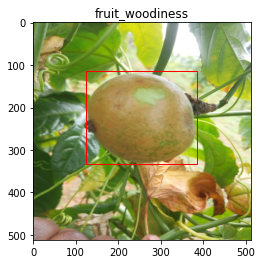

In [27]:
n = 3252
bboxes =  df[["xmin","ymin","width","height"]]
bboxes = np.array(bboxes)
id = df.iloc[n]["Image_ID"]
Class = df.iloc[n]["class"]
img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
imgplot = plt.imshow(img)
bbox = bboxes[n]

plt.title(Class)
coords = bbox_to_scaled_coords(bbox)*512
Coords = [int(x) for x in coords]
Coords = np.array(Coords)
bbox = coords_to_bbox(Coords)
plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [28]:
print(Coords)

[124 115 385 333]


[ 58.  119.  404.  365.5]
[ 58 119 404 365]
This Crop is of Shape: (246, 346, 3)


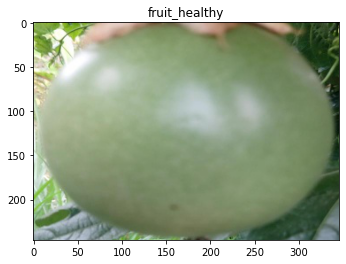

In [29]:
n = 346
bboxes =  df[["xmin","ymin","width","height"]]
bboxes = np.array(bboxes)
bbox = bboxes[n]
coords = bbox_to_scaled_coords(bbox)*512
print(coords)
Coords = [int(x) for x in coords]
Coords = np.array(Coords)
print(Coords)
id = df.iloc[n]["Image_ID"]
Class = df.iloc[n]["class"]
img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
img = img[Coords[1]:Coords[3],Coords[0]:Coords[2]]
imgplot = plt.imshow(img)
bbox = bboxes[n]
plt.title(Class)
print("This Crop is of Shape:", np.shape(img))

In [30]:
image_size = 300

class Fruit_Dataset_single(Dataset):
  def __init__(self,df,loc,image_size):
    #self.X = x
    self.Class = df["class"]
    self.BBOX = df[["xmin","ymin","width","height"]]
    self.Image_ID = df["Image_ID"]
    Bound_Boxes = []
    for bbox in bboxes:
      scaled_Box = bbox_to_scaled_coords(bbox)
      Bound_Boxes.append(scaled_Box)
    self.scaled_Bound_Boxes = Bound_Boxes
    Bound_Boxes = []
    for bbox in bboxes:
      xmin = bbox[0]
      ymin = bbox[1]
      w = bbox[2]
      h = bbox[3]
      xmax = xmin+w
      ymax = ymin+h
      Bound_Boxes.append([xmin, ymin, xmax, ymax])
    self.Unscaled_Bound_boxes = Bound_Boxes
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.Class)
  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        bboxes =  self.BBOX
        bboxes = np.array(bboxes)
        bbox = bboxes[n]
        coords = bbox_to_scaled_coords(bbox)*512
        Coords = [int(x) for x in coords]
        Coords = np.array(Coords)
        id = self.Image_ID[index]
        img=plt.imread("{}{}.jpg".format(loc,id))
        img = img[Coords[1]:Coords[3],Coords[0]:Coords[2]]
        X = self.transform(img)
        clss = self.Class[index]
        yclass = class_one_hot(clss)
        Ybbox = self.scaled_Bound_Boxes[index]
        ybbox = np.array(Ybbox)
        Y = []
        Y = yclass

        return X,Y

  transform = T.Compose([
        T.ToPILImage(),
        T.Resize([image_size,image_size]),
        T.ToTensor()])

In [31]:
loc = "/tmp/Train_Images/Train_Images/"
image_size = 300
fruity = Fruit_Dataset_single(df,loc,image_size)

torch.Size([3, 300, 300])


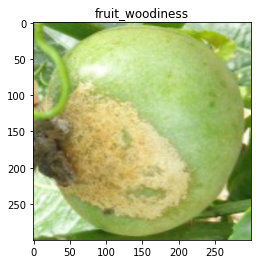

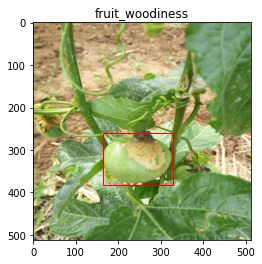

In [45]:
from scipy import ndimage
n = 124
X,y = fruity.__getitem__(n)
print(np.shape(X))
img = X.T
img1 = img
rotated_img = ndimage.rotate(X.T,-90)
plt.imshow(img)
plt.title(class_writer(y))


bboxes =  df[["xmin","ymin","width","height"]]
bboxes = np.array(bboxes)
id = df.iloc[n]["Image_ID"]

Class = df.iloc[n]["class"]
img=plt.imread("/tmp/Train_Images/Train_Images/{}.jpg".format(id))
img2 = img
plt.figure()
imgplot = plt.imshow(img)
bbox = bboxes[n]
plt.title(Class)
coords = bbox_to_scaled_coords(bbox)*512
Coords = [int(x) for x in coords]
Coords = np.array(Coords)
bbox = coords_to_bbox(Coords)
plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

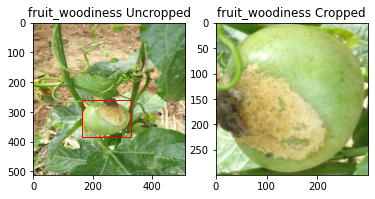

In [59]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img2)
axarr[0].title.set_text(Class+" Uncropped")
axarr[0].add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
axarr[1].imshow(img1)
axarr[1].title.set_text(Class+ " Cropped")
#axarr[1,0].imshow(img1)
#axarr[1,1].imshow(img2)

# Now We Can Construct Our Classifier

## First We  Normalize Our Images

In [34]:
n = 2356
X,y = fruity.__getitem__(n)
img = X.T

val = np.reshape(img[:,:,0], -1)
val = val.numpy()
np.mean(val)

0.53168327

In [35]:
n = 3256
X,y = fruity.__getitem__(n)
img = X.T
Means = []
Std = []
for i in range(len(img.T)):
  val = np.reshape(img[:,:,0], -1).numpy()
  Means.append(np.mean(val))
  Std.append(np.std(val))
print(Means)
print(Std)

[0.52140045, 0.52140045, 0.52140045]
[0.043358628, 0.043358628, 0.043358628]


In [36]:
len(img.T)

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.58413064, 0.58413064, 0.58413064]
[0.15908426, 0.15908426, 0.15908426]


Text(0.5, 1.0, 'Normalized Image')

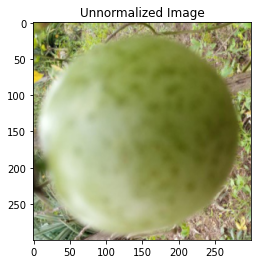

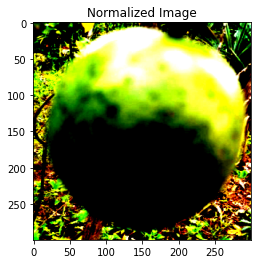

In [60]:
n = 1
X,y = fruity.__getitem__(n)
img = X.T
img1 = img

plt.imshow(img)
plt.title("Unnormalized Image")

img = X.T
Means = []
Std = []
for i in range(len(img.T)):
  val = np.reshape(img[:,:,0], -1).numpy()
  Means.append(np.mean(val))
  Std.append(np.std(val))
print(Means)
print(Std)


norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Means), (Std))])
plt.figure(2)
img = img.numpy()
img = np.array(img)
trans = norm_transform(img)
plt.imshow(trans.T,vmin=0, vmax=255)
plt.title("Normalized Image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


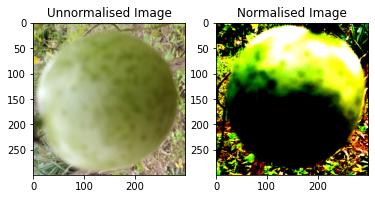

In [63]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1)
axarr[0].title.set_text("Unnormalised Image")
axarr[1].imshow(trans.T)
axarr[1].title.set_text("Normalised Image")

### Normalise Data From Training Set

In [38]:
loc = "/tmp/Train_Images/Train_Images/"
image_size = 300

train, test = train_test_split(df, test_size=0.2)
train.reset_index(inplace = True, drop = True)
test.reset_index()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
Training_set = Fruit_Dataset_single(train,loc,image_size)
Test_set = Fruit_Dataset_single(test,loc,image_size)

In [39]:
Mean_Mean = np.zeros(3)
Mean_Std = np.zeros(3)
N = Training_set.__len__()
#for n in N:
for n in range(Training_set.__len__()):
  if n%100 ==0:
    print(n)
  X,y = Training_set.__getitem__(n)
  img = X.T



  img = X.T
  Means = []
  Std = []
  for i in range(len(img.T)):
    val = np.reshape(img[:,:,i], -1).numpy()
    Means.append(np.mean(val))
    Std.append(np.std(val))
  Mean_Mean += Means
  Mean_Std += Std
Mean_Mean  =  Mean_Mean/N
Mean_Std  =  Mean_Std/N
print(Mean_Mean)
print(Mean_Std)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
[0.49023388 0.54192921 0.36727999]
[0.18881201 0.18629112 0.19820436]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'fruit_woodinessNormalised')

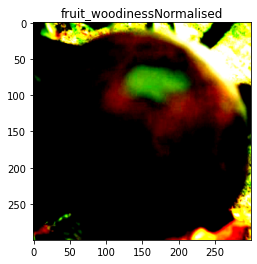

In [65]:
n = 1135
X,y = fruity.__getitem__(n)
img = X.T
img =np.array(img)
plt.title(class_writer(y)+"Unnormalised")
trans = norm_transform(img)
plt.imshow(trans.T,vmin=0, vmax=255)
plt.title(class_writer(y)+"Normalised")


In [42]:
image_size = 300
Means = Mean_Mean
Stds = Mean_Std
class Fruit_Dataset_single_norm(Dataset):
  def __init__(self,df,loc,image_size,Means,Stds,Norm=True):
    #self.X = x
    self.Norm = Norm
    self.Class = df["class"]
    self.BBOX = df[["xmin","ymin","width","height"]]
    self.Image_ID = df["Image_ID"]
    self.Means = Means
    self.Stds = Stds
    Bound_Boxes = []
    for bbox in bboxes:
      scaled_Box = bbox_to_scaled_coords(bbox)
      Bound_Boxes.append(scaled_Box)
    self.scaled_Bound_Boxes = Bound_Boxes
    Bound_Boxes = []
    for bbox in bboxes:
      xmin = bbox[0]
      ymin = bbox[1]
      w = bbox[2]
      h = bbox[3]
      xmax = xmin+w
      ymax = ymin+h
      Bound_Boxes.append([xmin, ymin, xmax, ymax])
    self.Unscaled_Bound_boxes = Bound_Boxes
  def __len__(self):
        'Denotes the total number of samples'
        return len(self.Class)
  def __getitem__(self, index,):
        'Generates one sample of data'
        # Select sample
        bboxes =  self.BBOX
        bboxes = np.array(bboxes)
        bbox = bboxes[n]
        coords = bbox_to_scaled_coords(bbox)*512
        Coords = [int(x) for x in coords]
        Coords = np.array(Coords)
        id = self.Image_ID[index]
        img=plt.imread("{}{}.jpg".format(loc,id))
        img = img[Coords[1]:Coords[3],Coords[0]:Coords[2]]
        X = self.transform(img)
        clss = self.Class[index]
        yclass = class_one_hot(clss)
        Ybbox = self.scaled_Bound_Boxes[index]
        ybbox = np.array(Ybbox)
        Y = []
        Y = yclass
        if self.Norm == True:
          X = norm_transform(X.numpy())

        return X,Y

  transform = T.Compose([
        T.ToPILImage(),
        T.Resize([image_size,image_size]),
        T.ToTensor()])
  norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Means), (Stds))])

In [43]:
  norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Means), (Stds))])
  transform = T.Compose([
        T.ToPILImage(),
        T.Resize([image_size,image_size]),
        T.ToTensor()])

In [ ]:
image_size

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


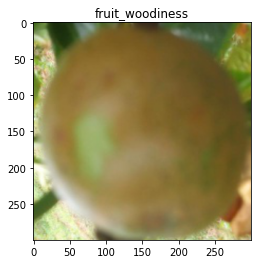

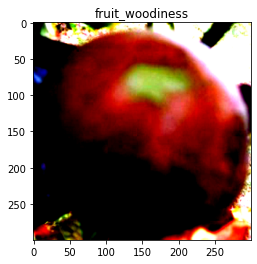

In [44]:
n = 1135
X,y = fruity.__getitem__(n)
img = X.T
plt.title(class_writer(y))
plt.imshow(img)

norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Mean_Mean), (Mean_Std))])
plt.figure(2)
plt.title(class_writer(y))
img = img.numpy()
img = np.array(img)
trans = norm_transform(img)
plt.imshow(trans.T,vmin=0, vmax=255)

In [ ]:
device

In [ ]:
loc = "/tmp/Train_Images/Train_Images/"
image_size = 300
Mean = Mean_Mean
Std = Mean_Std

train, test = train_test_split(df, test_size=0.2)
train.reset_index(inplace = True, drop = True)
test.reset_index(inplace = True, drop = True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
Training_set = Fruit_Dataset_single_norm(train,loc,image_size,Mean,Std,Norm = False)
Test_set = Fruit_Dataset_single_norm(test,loc,image_size,Mean,Std,Norm = False)

In [ ]:
n = 15
X,y = Training_set.__getitem__(n)
img = X.T

plt.figure()
plt.title(class_writer(y))
plt.imshow(img)

norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Mean_Mean), (Mean_Std))])
plt.figure(2)
plt.title(class_writer(y))
img = img.numpy()
img = np.array(img)
trans = norm_transform(img)
plt.imshow(trans.T,vmin=0, vmax=255)

In [ ]:
n = 1
X,y = Training_set.__getitem__(n)
img = X.T

plt.figure()
plt.title(class_writer(y))
plt.imshow(img)

# Now We Build A CNN

In [ ]:
class Net(nn.Module):
  ''' Models a simple Convolutional Neural Network'''

  def __init__(self):
    ''' initialize the network '''
    super(Net, self).__init__()
# 3 input image channel, 6 output channels, 
# 5x5 square convolution kernel
    self.conv1 = nn.Conv2d(in_channels = 3,out_channels = 6, kernel_size= 5)
    #self.conv1 =nn.Conv2d(3, 300, kernel_size=5, stride=1, padding=1)
# Max pooling over a (2, 2) window
    self.pool = nn.MaxPool2d(10, 10)
    self.conv2 = nn.Conv2d(6, 16, 5) 
    self.fc1 = nn.Linear(16 * 5 * 5, 120)# 5x5 from image dimension
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 3)

  def foreward(self, x):
    ''' the forward propagation algorithm '''
    x = self.pool(tF.relu(self.conv1(x)))
    x = self.pool(tF.relu(self.conv2(x)))
    #x = x.view(-1, 16 * 5 * 5)
    x = x.flatten(1)
    print(len(x))
    x = tF.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

net = Net()
print(net)

In [ ]:
loc = "/tmp/Train_Images/Train_Images/"
image_size = 300

train, test = train_test_split(df, test_size=0.2)
train.reset_index(inplace = True, drop = True)
test.reset_index()
device = 'cuda' if torch.cuda.is_available() else 'cpu'   
Training_set = Fruit_Dataset_single(train,loc,image_size)
Test_set = Fruit_Dataset_single(test,loc,image_size)

In [ ]:
X,y = Training_set.__getitem__(n)


norm_transform = T.Compose( 
    # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Mean_Mean), (Mean_Std))])
X = norm_transform(X.T.numpy())


net.foreward(X[None])

In [ ]:
# set batch_size
batch_size = 4

# set number of workers
num_workers = 2

trainloader = torch.utils.data.DataLoader(Training_set, batch_size=batch_size,
                                          shuffle=True, num_workers=num_workers)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net.foreward(inputs)

In [ ]:

start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# whatever you are timing goes here
end.record()

# Waits for everything to finish running
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))  # milliseconds


## Better Version

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 60)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 10)
        self.fc1 = nn.Linear(48400, 840)
        self.fc2 = nn.Linear(840,840)
        self.fc3 = nn.Linear(840, 84)
        self.fc4 = nn.Linear(84, 3)

    def forward(self, x):
      #print(np.shape(x))
      x = self.pool(F.relu(self.conv1(x)))
        
      #print(np.shape(x))
      x = self.pool(F.relu(self.conv2(x)))
        
      #print(np.shape(x))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
        
      #print(np.shape(x))
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = self.fc4(x)
      return x


net = Net()
print(net)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

batch_size = 10
trainset = Training_set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = Test_set
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
classes = ('fruit_woodiness', 'fruit_brownspot', 'fruit_healthy')

norm_transform = T.Compose( # composing several transforms together
    [T.ToTensor(), # to tensor object
     T.Normalize((Mean_Mean), (Mean_Std))])

In [ ]:

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        print(i)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 0:    # print every 5 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 5))
            running_loss = 0.0

print('Finished Training')